<a href="https://colab.research.google.com/github/yu-hidaka/AD-DIFFI/blob/main/simulation_ch3_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

DIFFI bias validation code execution started
--- DIFFI Binary Noise Overestimation Simulation (N=100) ---
Dataset size: 1000, Number of features: 3
True anomaly proportion: 5.00% (labels are random)

--- Detailed CFIS Analysis Results ---
IF Model Avg F1 Score (Random Labels): 0.0816
| Feature      |   DIFFI_Score_Mean |   Avg_CFIS_Outliers (Numerator) |   Avg_CFIS_Inliers (Denominator) |   Avg_Split_Count_Per_Tree |
|:-------------|-------------------:|--------------------------------:|---------------------------------:|---------------------------:|
| F_binary     |             1.2435 |                         96.1698 |                          1619.83 |                     462.67 |
| F_continuous |             0.692  |                        201.091  |                          7819.05 |                    5388.51 |
| F_noise      |             0.6835 |                        198.455  |                          7818.64 |                    5384.56 |

--- Validation ---
F_binary score:

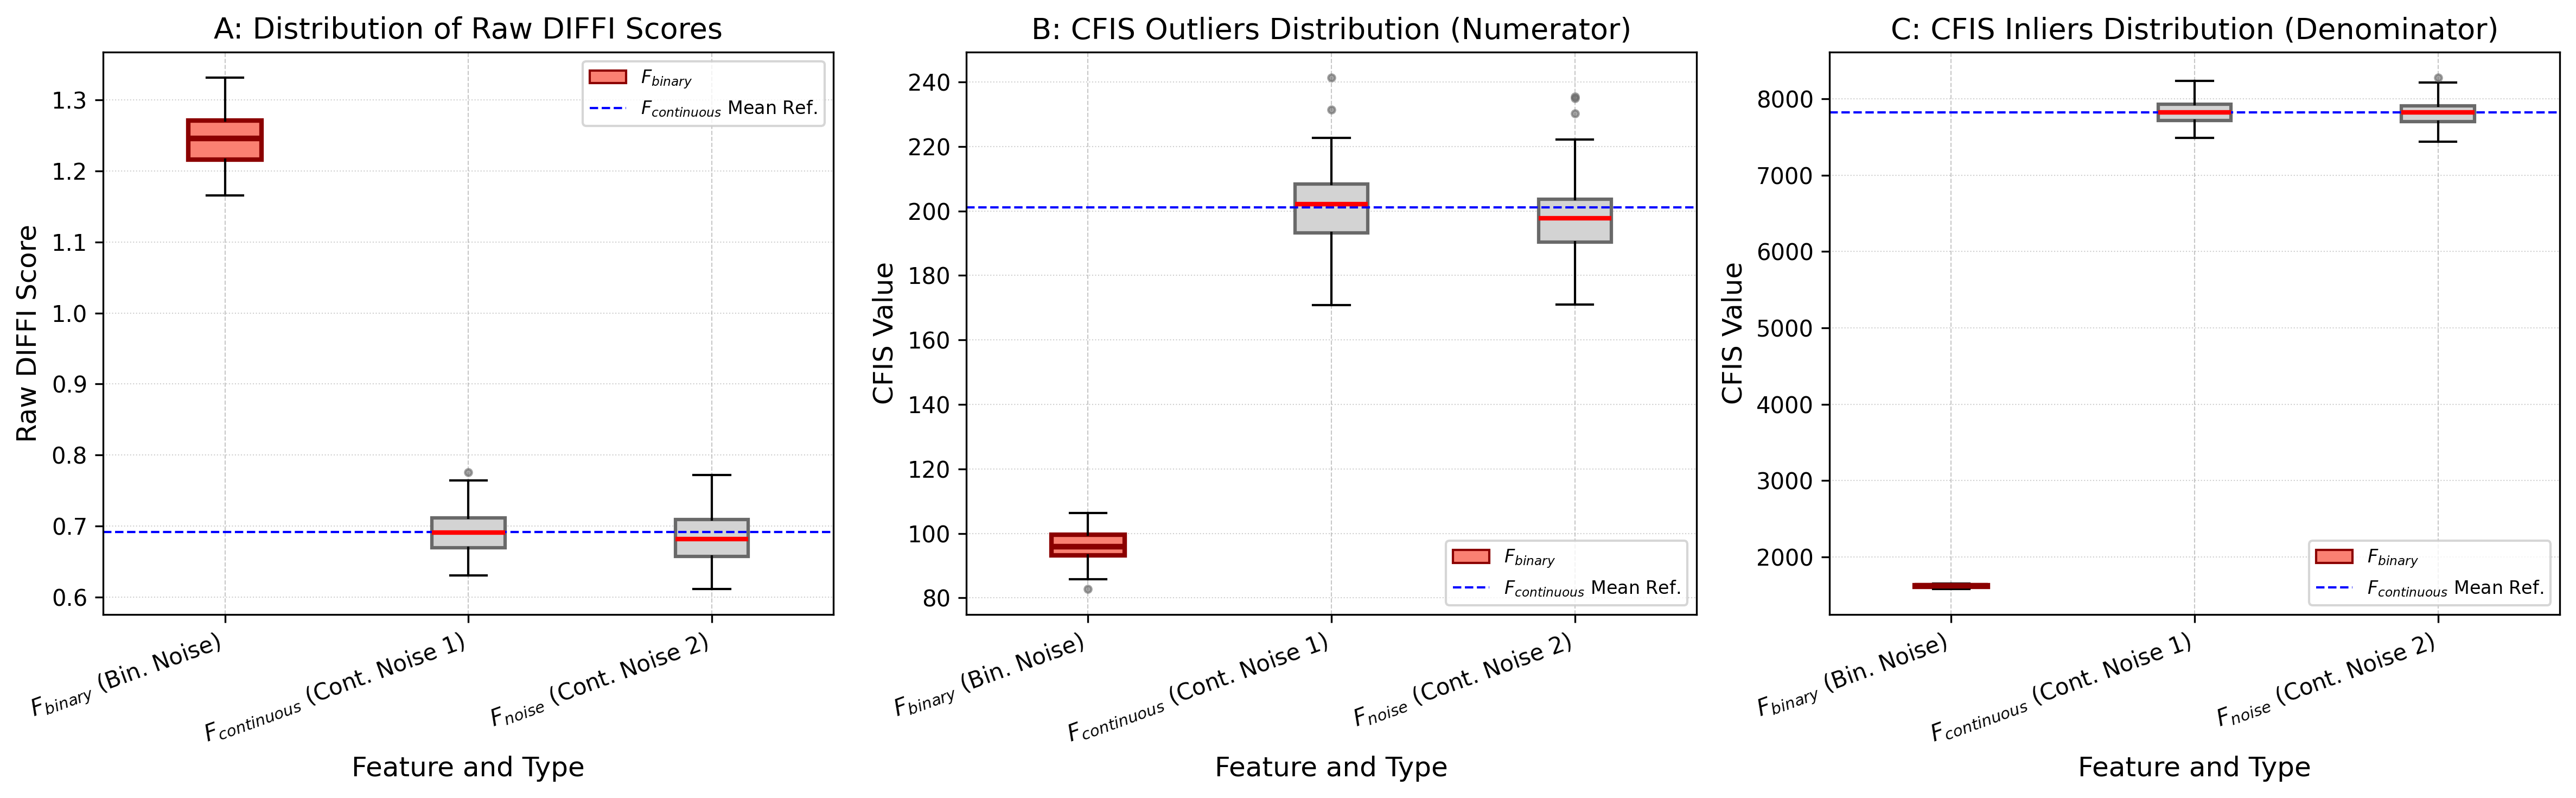

Execution completed: Boxplots displayed


In [3]:
import numpy as np
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.metrics import f1_score
from collections import Counter
from math import ceil
from scipy.special import digamma
import matplotlib.pyplot as plt
import time


# ====================================================================
# A. Required functions from original DIFFI repository
# ====================================================================


def _average_path_length(n_samples_leaf):
    n_samples_leaf = np.asarray(n_samples_leaf)
    mask = n_samples_leaf <= 1
    n_samples_leaf = n_samples_leaf.copy()
    n_samples_leaf[mask] = 2
    return (2.0 * (np.log(n_samples_leaf - 1.0) + np.euler_gamma) -
            (2.0 * (n_samples_leaf - 1.0) / n_samples_leaf))


def _num_samples(X):
    return X.shape[0]


def _get_iic(estimator, predictions, is_leaves, adjust_iic=True):
    desired_min = 0.5
    desired_max = 1.0
    epsilon = 0.0
    n_nodes = estimator.tree_.node_count
    lambda_ = np.zeros(n_nodes)
    children_left = estimator.tree_.children_left
    children_right = estimator.tree_.children_right

    if predictions.shape[0] == 0:
        return lambda_

    node_indicator_all_samples = estimator.decision_path(predictions).toarray()
    num_samples_in_node = np.sum(node_indicator_all_samples, axis=0)

    for node in range(n_nodes):
        num_samples_in_current_node = num_samples_in_node[node]
        num_samples_in_left_children = num_samples_in_node[children_left[node]]
        num_samples_in_right_children = num_samples_in_node[children_right[node]]

        if num_samples_in_current_node == 0 or num_samples_in_current_node == 1 or is_leaves[node]:
            lambda_[node] = -1
        elif num_samples_in_left_children == 0 or num_samples_in_right_children == 0:
            lambda_[node] = epsilon
        else:
            current_min = 0.5 if num_samples_in_current_node % 2 == 0 else ceil(num_samples_in_current_node / 2) / num_samples_in_current_node
            current_max = (num_samples_in_current_node - 1) / num_samples_in_current_node
            tmp = np.max([num_samples_in_left_children, num_samples_in_right_children]) / num_samples_in_current_node

            if adjust_iic and current_min != current_max:
                lambda_[node] = ((tmp - current_min) / (current_max - current_min)) * (desired_max - desired_min) + desired_min
            else:
                lambda_[node] = tmp
    return lambda_


def diffi_ib_global_logic(iforest, X, adjust_iic=True):
    start = time.time()
    num_feat = X.shape[1]
    estimators = iforest.estimators_
    cfi_outliers_ib = np.zeros(num_feat).astype('float')
    cfi_inliers_ib = np.zeros(num_feat).astype('float')
    counter_outliers_ib = np.zeros(num_feat).astype('int')
    counter_inliers_ib = np.zeros(num_feat).astype('int')
    in_bag_samples = iforest.estimators_samples_

    as_full = iforest.decision_function(X)

    for k, estimator in enumerate(estimators):
        in_bag_sample = list(in_bag_samples[k])
        X_ib = X[in_bag_sample, :]
        as_ib = as_full[in_bag_sample]

        X_outliers_ib = X_ib[np.where(as_ib < 0)]
        X_inliers_ib = X_ib[np.where(as_ib > 0)]

        if X_inliers_ib.shape[0] == 0 or X_outliers_ib.shape[0] == 0:
            continue

        n_nodes = estimator.tree_.node_count
        children_left = estimator.tree_.children_left
        children_right = estimator.tree_.children_right
        feature = estimator.tree_.feature
        node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
        is_leaves = np.zeros(shape=n_nodes, dtype=bool)

        stack = [(0, -1)]
        while len(stack) > 0:
            node_id, parent_depth = stack.pop()
            node_depth[node_id] = parent_depth + 1
            if (children_left[node_id] != children_right[node_id]):
                stack.append((children_left[node_id], parent_depth + 1))
                stack.append((children_right[node_id], parent_depth + 1))
            else:
                is_leaves[node_id] = True

        # OUTLIERS
        lambda_outliers_ib = _get_iic(estimator, X_outliers_ib, is_leaves, adjust_iic)
        node_indicator_all_points_outliers_ib = estimator.decision_path(X_outliers_ib)
        node_indicator_all_points_array_outliers_ib = node_indicator_all_points_outliers_ib.toarray()

        for i in range(len(X_outliers_ib)):
            path = list(np.where(node_indicator_all_points_array_outliers_ib[i] == 1)[0])
            if not path:
                continue
            depth = node_depth[path[-1]]

            for node in path:
                current_feature = feature[node]
                lambda_val = lambda_outliers_ib[node]

                if current_feature >= 0 and current_feature < num_feat and lambda_val != -1:
                    cfi_outliers_ib[current_feature] += (1 / depth) * lambda_val
                    counter_outliers_ib[current_feature] += 1

        # INLIERS
        lambda_inliers_ib = _get_iic(estimator, X_inliers_ib, is_leaves, adjust_iic)
        node_indicator_all_points_inliers_ib = estimator.decision_path(X_inliers_ib)
        node_indicator_all_points_array_inliers_ib = node_indicator_all_points_inliers_ib.toarray()

        for i in range(len(X_inliers_ib)):
            path = list(np.where(node_indicator_all_points_array_inliers_ib[i] == 1)[0])
            if not path:
                continue
            depth = node_depth[path[-1]]

            for node in path:
                current_feature = feature[node]
                lambda_val = lambda_inliers_ib[node]

                if current_feature >= 0 and current_feature < num_feat and lambda_val != -1:
                    cfi_inliers_ib[current_feature] += (1 / depth) * lambda_val
                    counter_inliers_ib[current_feature] += 1

    fi_outliers_ib = np.where(counter_outliers_ib > 0, cfi_outliers_ib / counter_outliers_ib, 0)
    fi_inliers_ib = np.where(counter_inliers_ib > 0, cfi_inliers_ib / counter_inliers_ib, 0)
    fi_ib = np.divide(fi_outliers_ib, fi_inliers_ib, out=np.zeros_like(fi_outliers_ib), where=fi_inliers_ib != 0)

    return fi_ib, cfi_outliers_ib, cfi_inliers_ib, counter_outliers_ib, counter_inliers_ib


# ====================================================================
# B. Main execution code
# ====================================================================


def diffi_ranks_with_split_count(X, y, n_trees, max_samples, contamination, n_iter, diffi_func):
    f1_all, fi_diffi_all_list = [], []
    cfi_out_all, cfi_in_all = [], []
    split_counts_total = np.zeros(X.shape[1], dtype=float)
    X_np = X.values

    for k in range(n_iter):
        iforest = IsolationForest(
            n_estimators=n_trees, max_samples=max_samples,
            contamination=contamination, random_state=k, bootstrap=False,
        )
        iforest.fit(X_np)
        y_pred = np.array(iforest.decision_function(X_np) < 0).astype('int')
        f1_all.append(f1_score(y, y_pred))

        fi_diffi, cfi_out, cfi_in, _, _ = diffi_func(iforest, X_np, adjust_iic=True)
        fi_diffi_all_list.append(fi_diffi)
        cfi_out_all.append(cfi_out)
        cfi_in_all.append(cfi_in)

        split_counts_iter = np.zeros(X.shape[1], dtype=float)
        for estimator in iforest.estimators_:
            split_features = estimator.tree_.feature
            split_features = split_features[split_features >= 0]
            counts = Counter(split_features)
            for idx, cnt in counts.items():
                split_counts_iter[idx] += cnt
        split_counts_total += split_counts_iter

    avg_f1 = np.mean(f1_all)
    fi_diffi_matrix = np.vstack(fi_diffi_all_list)
    fi_diffi_mean = np.mean(fi_diffi_matrix, axis=0)
    cfis_out_matrix = np.vstack(cfi_out_all)
    cfis_in_matrix = np.vstack(cfi_in_all)
    cfis_out_avg = np.mean(cfis_out_matrix, axis=0)
    cfis_in_avg = np.mean(cfis_in_matrix, axis=0)
    split_counts_avg = split_counts_total / n_iter

    return fi_diffi_mean, avg_f1, split_counts_avg, cfis_out_avg, cfis_in_avg, fi_diffi_matrix, cfis_out_matrix, cfis_in_matrix


def run_diffi_bias_test(n_iter=100, n_trees=100, max_samples=256, contamination=0.05):
    print("--- DIFFI Binary Noise Overestimation Simulation (N=100) ---")

    n_total = 1000
    p_anomaly = contamination
    rng = np.random.default_rng(seed=42)

    F_cont_all = rng.uniform(low=0, high=10, size=n_total)
    F_noise_all = rng.uniform(low=0, high=10, size=n_total)
    p_binary_noise = 0.5
    F_binary_all = rng.binomial(1, p_binary_noise, n_total)

    y_true_indices = np.zeros(n_total, dtype=int)
    n_anomaly = int(n_total * p_anomaly)
    y_true_indices[rng.choice(n_total, n_anomaly, replace=False)] = 1

    df = pd.DataFrame({
        'F_binary': F_binary_all,
        'F_continuous': F_cont_all,
        'F_noise': F_noise_all,
        'Y': y_true_indices
    })
    df = df.sample(frac=1, random_state=42).reset_index(drop=True)

    X = df[['F_binary', 'F_continuous', 'F_noise']]
    y_true = df['Y'].values
    FEATURE_NAMES = X.columns.tolist()

    # xtick labels (text + math)
    BOXPLOT_LABELS_MATH = [
        r'$F_{binary}$ (Bin. Noise)',
        r'$F_{continuous}$ (Cont. Noise 1)',
        r'$F_{noise}$ (Cont. Noise 2)'
    ]
    # legend labels (math only)
    LEGEND_LABELS = [
        r'$F_{binary}$',
        r'$F_{continuous}$',
        r'$F_{noise}$'
    ]

    BINARY_INDEX = 0
    CONT_REF_INDEX = 1

    print(f"Dataset size: {X.shape[0]}, Number of features: {X.shape[1]}")
    print(f"True anomaly proportion: {p_anomaly * 100:.2f}% (labels are random)")

    fi_diffi_mean, avg_f1, split_counts_avg, cfis_out_avg, cfis_in_avg, \
        fi_diffi_matrix, cfis_out_matrix, cfis_in_matrix = diffi_ranks_with_split_count(
            X, y_true, n_trees=n_trees, max_samples=max_samples,
            contamination=contamination, n_iter=n_iter, diffi_func=diffi_ib_global_logic
        )

    results = pd.DataFrame({
        'Feature': FEATURE_NAMES,
        'DIFFI_Score_Mean': fi_diffi_mean,
        'Avg_CFIS_Outliers (Numerator)': cfis_out_avg,
        'Avg_CFIS_Inliers (Denominator)': cfis_in_avg,
        'Avg_Split_Count_Per_Tree': split_counts_avg
    })

    print("\n--- Detailed CFIS Analysis Results ---")
    print(f"IF Model Avg F1 Score (Random Labels): {avg_f1:.4f}")
    print(results.sort_values(by='DIFFI_Score_Mean', ascending=False).round(4).to_markdown(index=False))

    score_binary = results[results['Feature'] == 'F_binary']['DIFFI_Score_Mean'].iloc[0]
    score_cont_1 = results[results['Feature'] == 'F_continuous']['DIFFI_Score_Mean'].iloc[0]

    print("\n--- Validation ---")
    print(f"F_binary score: {score_binary:.4f}")
    print(f"F_continuous score (Cont. Noise 1): {score_cont_1:.4f}")
    print(f"F_binary score / F_continuous score = {score_binary / score_cont_1:.2f}x")

    if score_binary > score_cont_1 * 1.1:
        print("\nConclusion: F_binary score is significantly higher than F_continuous, confirming DIFFI's bias towards overestimating binary features.")
        print("Cause: Continuous noise accumulates excessively in denominator (inlier CFIS), while binary noise shows suppressed accumulation, resulting in higher DIFFI ratio.")
    else:
        print("\nConclusion: No significant difference in scores observed.")

    return (fi_diffi_matrix, cfis_out_matrix, cfis_in_matrix,
            fi_diffi_mean, cfis_out_avg, cfis_in_avg,
            BOXPLOT_LABELS_MATH, LEGEND_LABELS,
            FEATURE_NAMES, BINARY_INDEX, CONT_REF_INDEX, n_iter)


# ====================================================================
# Execution and plotting (display only)
# ====================================================================


print("DIFFI bias validation code execution started")
(fi_diffi_matrix, cfis_out_matrix, cfis_in_matrix,
 fi_diffi_mean, cfis_out_avg, cfis_in_avg,
 BOXPLOT_LABELS_MATH, LEGEND_LABELS,
 FEATURE_NAMES, BINARY_INDEX, CONT_REF_INDEX, n_iter) = run_diffi_bias_test(n_iter=100)

print("\n### DIFFI Bias Validation Boxplot Display ###")

plt.rcParams.update({
    'font.size': 10,
    'axes.labelsize': 12,
    'axes.titlesize': 14,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 9,
    'figure.figsize': (16, 5),
    'axes.grid': True,
    'grid.linestyle': '--',
    'grid.linewidth': 0.5,
    'grid.alpha': 0.7,
    'boxplot.boxprops.linewidth': 1.5,
    'boxplot.medianprops.linewidth': 2,
    'text.usetex': False,  # using mathtext
})

fig, axes = plt.subplots(1, 3, figsize=(16, 5), dpi=300)


def plot_and_highlight(ax, data, title, ylabel, loc,
                      show_y_label=True, median_ref_val=None,
                      feature_names=None, boxplot_labels=None,
                      legend_labels=None, binary_index=0, cont_ref_index=1):

    box_plots = ax.boxplot(
        data, vert=True, patch_artist=True,
        medianprops=dict(color='red', linewidth=2),
        boxprops=dict(facecolor='lightgray', color='dimgray', linewidth=1.5),
        flierprops=dict(marker='o', markersize=3,
                        markerfacecolor='dimgray', markeredgecolor='dimgray',
                        alpha=0.6)
    )

    # Highlight F_binary
    box_plots['boxes'][binary_index].set_facecolor('salmon')
    box_plots['boxes'][binary_index].set_edgecolor('darkred')
    box_plots['boxes'][binary_index].set_linewidth(2)
    box_plots['medians'][binary_index].set_color('darkred')
    box_plots['medians'][binary_index].set_linewidth(2.5)

    # xtick: subscript text + math
    ax.set_xticks(np.arange(1, len(feature_names) + 1))
    ax.set_xticklabels(boxplot_labels, rotation=20, ha='right', fontsize=10)

    ax.set_title(title, fontsize=13)
    ax.set_xlabel('Feature and Type', fontsize=12)
    if show_y_label:
        ax.set_ylabel(ylabel, fontsize=12)

    handles, labels = [], []

    # Legend: math-only legend_labels
    dummy_signal = plt.Rectangle(
        (0, 0), 1, 1,
        fc='salmon', ec='darkred',
        label=legend_labels[binary_index]
    )
    handles.append(dummy_signal)
    labels.append(legend_labels[binary_index])

    if median_ref_val is not None:
        ax.axhline(median_ref_val, color='blue', linestyle='--', linewidth=1.0)
        handles.append(plt.Line2D([0], [0], color='blue', linestyle='--', linewidth=1.0))
        # Reference line legend label also in mathtext
        labels.append(r'$F_{continuous}$ Mean Ref.')

    ax.grid(axis='y', linestyle=':', alpha=0.6)
    ax.legend(handles=handles, labels=labels, loc=loc, frameon=True, fontsize=8)


# Create 3 boxplots
plot_and_highlight(
    axes[0], fi_diffi_matrix,
    'A: Distribution of Raw DIFFI Scores', 'Raw DIFFI Score',
    loc='upper right',
    median_ref_val=fi_diffi_mean[CONT_REF_INDEX],
    feature_names=FEATURE_NAMES,
    boxplot_labels=BOXPLOT_LABELS_MATH,
    legend_labels=LEGEND_LABELS,
    binary_index=BINARY_INDEX,
    cont_ref_index=CONT_REF_INDEX
)

plot_and_highlight(
    axes[1], cfis_out_matrix,
    'B: CFIS Outliers Distribution (Numerator)', 'CFIS Value',
    loc='lower right',
    median_ref_val=cfis_out_avg[CONT_REF_INDEX],
    feature_names=FEATURE_NAMES,
    boxplot_labels=BOXPLOT_LABELS_MATH,
    legend_labels=LEGEND_LABELS,
    binary_index=BINARY_INDEX,
    cont_ref_index=CONT_REF_INDEX
)

plot_and_highlight(
    axes[2], cfis_in_matrix,
    'C: CFIS Inliers Distribution (Denominator)', 'CFIS Value',
    loc='lower right',
    median_ref_val=cfis_in_avg[CONT_REF_INDEX],
    feature_names=FEATURE_NAMES,
    boxplot_labels=BOXPLOT_LABELS_MATH,
    legend_labels=LEGEND_LABELS,
    binary_index=BINARY_INDEX,
    cont_ref_index=CONT_REF_INDEX
)

plt.tight_layout()
plt.show()

print("Execution completed: Boxplots displayed")
